---
title: "Decision Trees"
author: "Ali Zaidi"
date: "2025-12-3"
categories: [Time Series, Decision Trees, XGBoost]
description: "Lets try some simple and traditional machine learning approaches, like random forests, gradient boosted trees and some souped up linear regression methods"
format:
  html:
    code-fold: true
jupyter: python3
---

In [1]:
#| include: false 
from fastai.vision.all import *
from eagle_swing.clipper import *
from eagle_swing.plot import *
from eagle_swing.temporal import *
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
from tqdm import tqdm
import shap
#%matplotlib widget

In [2]:
#| include: false
plt.style.use('dark_background')

In [3]:
#cleaned_df_paths =[fpath for fpath in get_files('../../../data/full_videos/ymirza/', extensions='.csv') if fpath.name=='clean_lbls.csv']
cleaned_df_paths =[fpath for fpath in get_files('.', extensions='.csv') ]
cleaned_df_paths

[Path('nov16_df.csv'), Path('sep14_df.csv'), Path('oct25_df.csv')]

In [4]:
df_holder = []
for df_path in cleaned_df_paths:
    df_holder.append(pd.read_csv(df_path))
cleaned_df = pd.concat(df_holder).reset_index(drop=True)
cleaned_df.shape

(133, 10)

In [5]:
cleaned_df.head(1)

,clip_name,video_name,swing_index,score,pkl_path,first_higher_wrists_backswing_frame,swing_day,start_idx,end_idx,top_backswing_idx
0,IMG_1023_swing_0_score_1,IMG_1023,0,1,../../../data/full_videos/ymirza/aug9/IMG_1023/keypoints/IMG_1023.pkl,1540,aug9,1530,1560,1550


In [60]:
before_increment = 25
after_increment = 15
cleaned_df['start_idx'] = cleaned_df['top_backswing_idx'] - before_increment
cleaned_df['end_idx'] = cleaned_df['top_backswing_idx'] + after_increment

In [32]:
(cleaned_df.score == 5).sum(), (cleaned_df.score == 1).sum()

(25, 32)

In [33]:
rand_idxs = np.random.randint(0, 25, 10)
df1 = cleaned_df[cleaned_df.score == 1].reset_index(drop=True).iloc[rand_idxs].reset_index(drop=True)
df5 = cleaned_df[cleaned_df.score == 5].reset_index(drop=True).iloc[rand_idxs].reset_index(drop=True)

#df1 = cleaned_df[cleaned_df.score == 1].reset_index(drop=True).iloc[:15].reset_index(drop=True)
#df5 = cleaned_df[cleaned_df.score == 5].reset_index(drop=True).iloc[:15].reset_index(drop=True)

test_df = pd.concat([df1, df5]).reset_index(drop=True)

In [34]:
#swing = SwingExtractor(test_df.iloc[len(test_df)])
swings = [SwingExtractor(test_df.iloc[x]) for x in range(len(test_df))]
kps_list = [swings[x].kps for x in range(len(swings))]
lbls = [swings[x].clip_name for x in range(len(swings))]
scores = [swing.row.score for swing in swings]
lbls[:5]

['IMG_1086_swing_2_score_1',
 'IMG_1092_swing_1_score_1',
 'IMG_1092_swing_4_score_1',
 'IMG_1088_swing_0_score_1',
 'IMG_1092_swing_5_score_1']

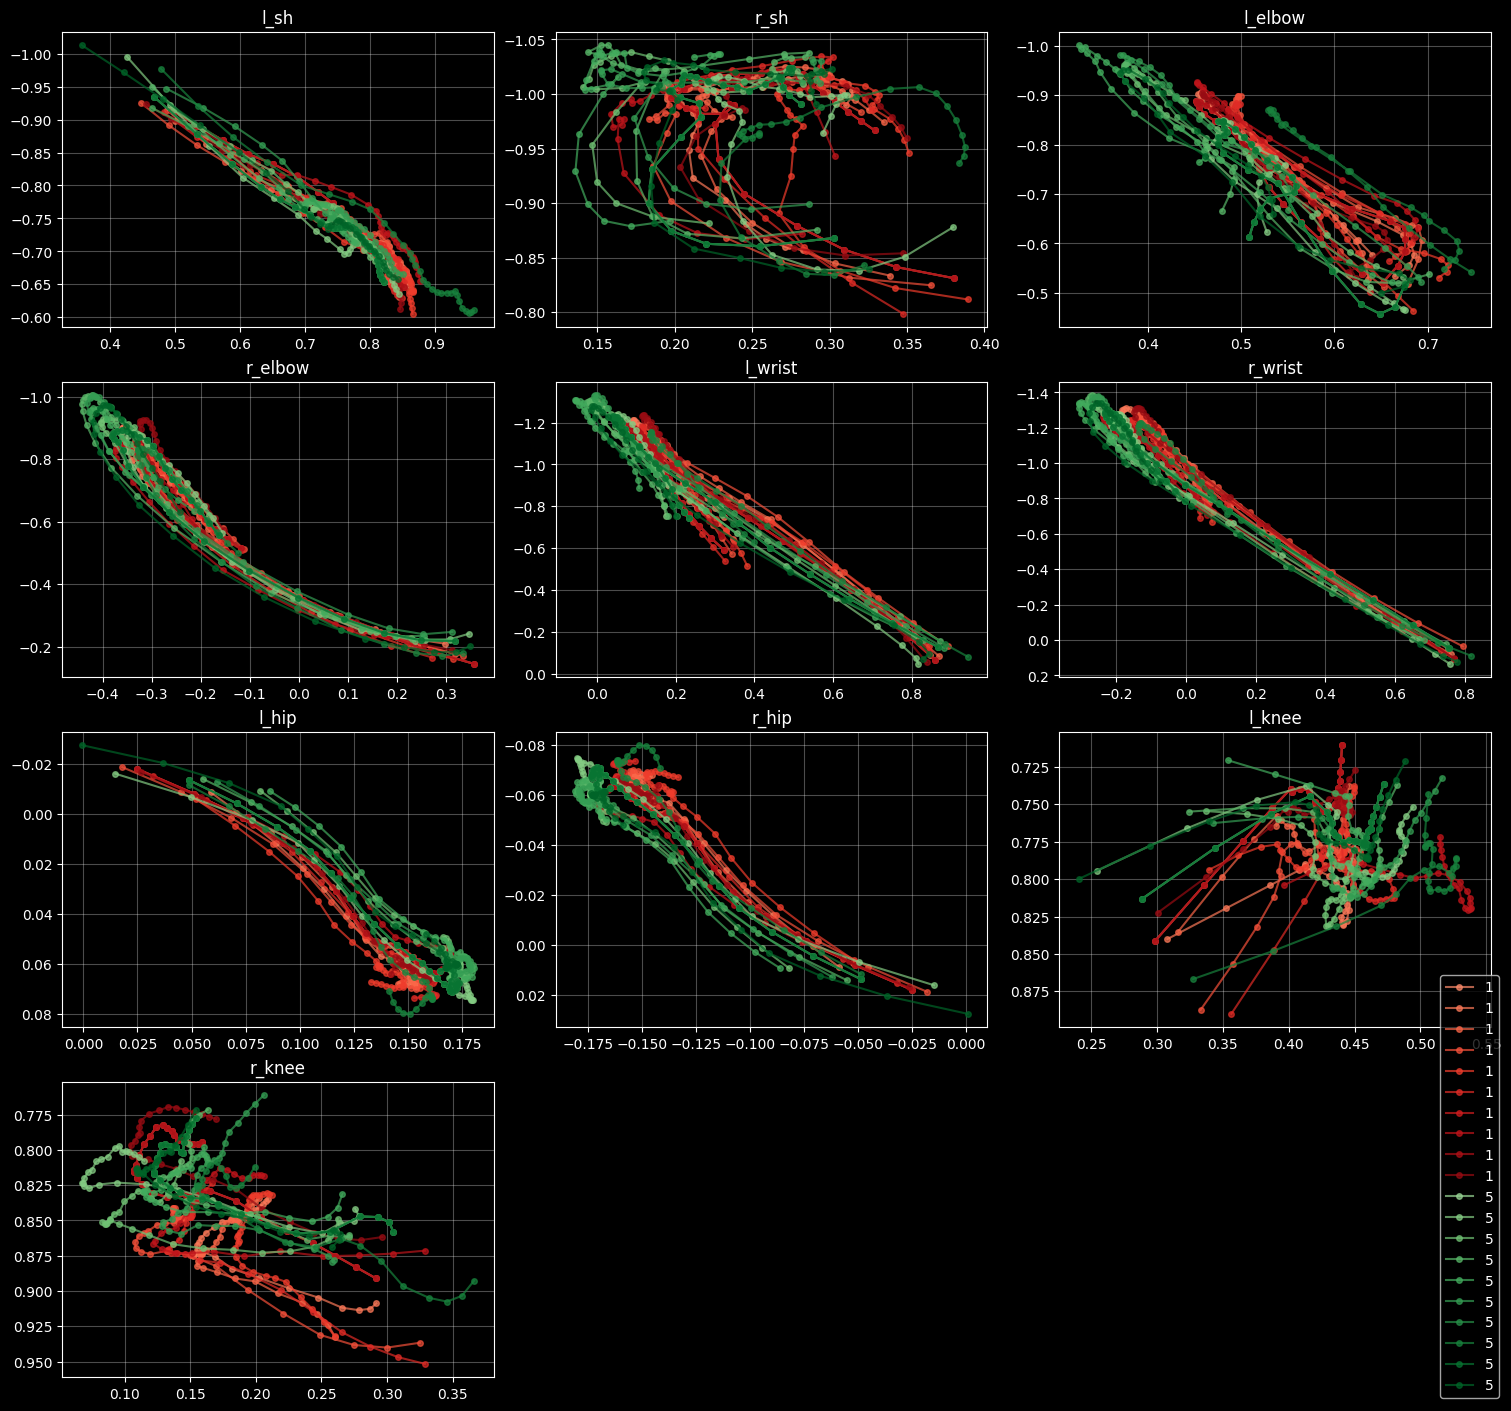

In [35]:
plot_attributes(kps_list, ['l_sh', 'r_sh', 'l_elbow', 'r_elbow',
                              'l_wrist', 'r_wrist', 'l_hip', 'r_hip',
                               'l_knee', 'r_knee',
                              ], 
                scores, scatter=True)

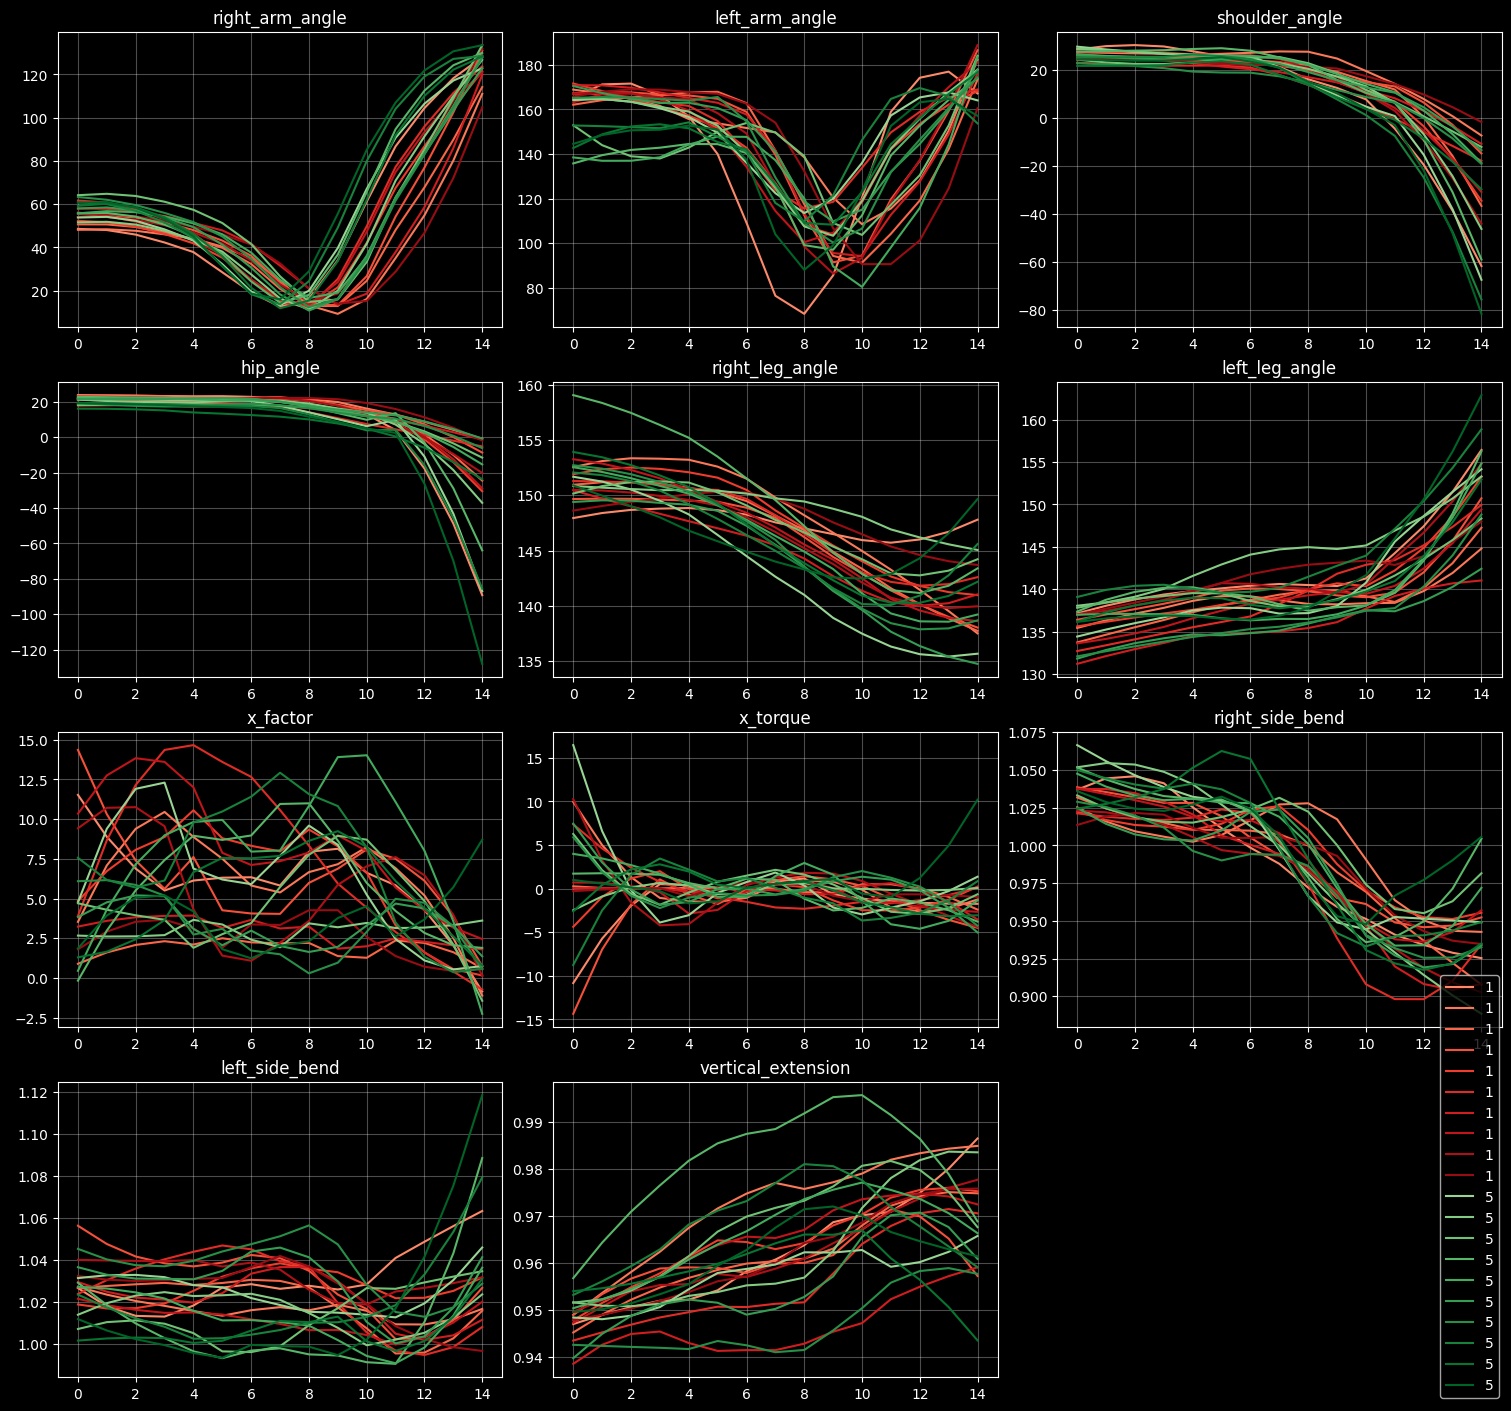

In [26]:
attributes = ["right_arm_angle", "left_arm_angle", "shoulder_angle", 
                "hip_angle", "right_leg_angle", "left_leg_angle", 
                "x_factor", "x_torque", "right_side_bend",
                "left_side_bend", "vertical_extension"
             ]
plot_attributes(swings, attributes, scores, scatter=False)

In [17]:
import matplotlib.cm as cm

def plot_attributes(instances, attr_list, 
                    instance_labels=None,
                    scatter=False,
                    smooth=True,           # <--- New Toggle
                    window_len=7,          # <--- Smoothing intensity (must be odd)
                    poly_order=2):         # <--- Polynomial order (2 or 3 is best)
    """
    Plots attributes with distinct hues, connected scatter points, 
    and INVERTED Y-AXIS (video coordinate style).
    """
    n_plots = len(attr_list)
    cols = 3
    rows = math.ceil(n_plots / cols)

    if instance_labels is None:
        instance_labels = [f"Instance {i}" for i in range(len(instances))]

    # --- Pre-calculate Colors ---
    red_indices = [i for i, lbl in enumerate(instance_labels) if lbl == 1]
    green_indices = [i for i, lbl in enumerate(instance_labels) if lbl != 1]
    
    red_colors = cm.Reds(np.linspace(0.4, 0.9, len(red_indices)))
    green_colors = cm.Greens(np.linspace(0.4, 0.9, len(green_indices)))
    
    instance_colors = [None] * len(instances)
    for i, idx in enumerate(red_indices):
        instance_colors[idx] = red_colors[i]
    for i, idx in enumerate(green_indices):
        instance_colors[idx] = green_colors[i]

    # --- Plotting ---
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3.5 * rows), constrained_layout=True)
    
    if isinstance(axes, np.ndarray):
        axes_flat = axes.flatten()
    else:
        axes_flat = [axes]

    for i, ax in enumerate(axes_flat):
        if i < n_plots:
            attr_name = attr_list[i]
            ax.set_title(attr_name)
            
            # --- INVERT Y-AXIS HERE ---
            if scatter: 
                ax.invert_yaxis()
            
            for j, instance in enumerate(instances):
                if hasattr(instance, attr_name):
                    data = getattr(instance, attr_name)
                    
                    # --- SMOOTHING LOGIC ---
                    if smooth and len(data) > window_len:
                        # axis=0 ensures we smooth 'over time' (rows) for both X and Y columns
                        try:
                            data = savgol_filter(data, window_len, poly_order, axis=0) 
                        except Exception as e:
                            print(f"Skipping smoothing for {attr_name}: {e}")
                    
                    lbl = instance_labels[j] if i == 0 else "_nolegend_"
                    c = instance_colors[j]

                    if scatter:
                        # Assuming data is (N, 2)
                        ax.plot(data[:, 0], data[:, 1], 
                                color=c, label=lbl,
                                marker='o', linestyle='-', 
                                markersize=4, alpha=0.7)
                    else:
                        # Assuming data is (N,) or (N, 1)
                        ax.plot(data, color=c, label=lbl)
                else:
                    print(f"Warning: Attribute '{attr_name}' missing in {instance_labels[j]}")

            ax.grid(True, alpha=0.3)
        else:
            ax.axis('off')

    if len(axes_flat) > 0:
        handles, labels = axes_flat[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(1, 0), bbox_transform=fig.transFigure)

    plt.show()

In [193]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import numpy as np

def plot_attributes(instances, attr_list, 
                    instance_labels=None,
                    scatter=False):
    """
    Plots attributes with distinct hues, connected scatter points, 
    and INVERTED Y-AXIS (video coordinate style).
    """
    n_plots = len(attr_list)
    cols = 3
    rows = math.ceil(n_plots / cols)

    if instance_labels is None:
        instance_labels = [f"Instance {i}" for i in range(len(instances))]

    # --- Pre-calculate Colors ---
    red_indices = [i for i, lbl in enumerate(instance_labels) if lbl == 1]
    green_indices = [i for i, lbl in enumerate(instance_labels) if lbl != 1]
    
    red_colors = cm.Reds(np.linspace(0.4, 0.9, len(red_indices)))
    green_colors = cm.Greens(np.linspace(0.4, 0.9, len(green_indices)))
    
    instance_colors = [None] * len(instances)
    for i, idx in enumerate(red_indices):
        instance_colors[idx] = red_colors[i]
    for i, idx in enumerate(green_indices):
        instance_colors[idx] = green_colors[i]

    # --- Plotting ---
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3.5 * rows), constrained_layout=True)
    
    if isinstance(axes, np.ndarray):
        axes_flat = axes.flatten()
    else:
        axes_flat = [axes]

    for i, ax in enumerate(axes_flat):
        if i < n_plots:
            attr_name = attr_list[i]
            ax.set_title(attr_name)
            
            # --- INVERT Y-AXIS HERE ---
            # Call this ONCE per subplot, before or after plotting data
            ax.invert_yaxis()
            # This makes 0 appear at the top and larger values at the bottom
            
            for j, instance in enumerate(instances):
                if hasattr(instance, attr_name):
                    data = getattr(instance, attr_name)
                    
                    lbl = instance_labels[j] if i == 0 else "_nolegend_"
                    c = instance_colors[j]

                    if scatter:
                        ax.plot(data[:, 0], data[:, 1], 
                                color=c, label=lbl,
                                marker='o', linestyle='-', 
                                markersize=3, alpha=0.5)
                    else:
                        ax.plot(data, color=c, label=lbl)
                else:
                    print(f"Warning: Attribute '{attr_name}' missing in {instance_labels[j]}")

            ax.grid(True, alpha=0.3)
        else:
            ax.axis('off')

    if len(axes_flat) > 0:
        handles, labels = axes_flat[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(1, 0), bbox_transform=fig.transFigure)

    plt.show()

In [140]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import numpy as np

def plot_attributes(instances, attr_list, 
                    instance_labels=None,
                    scatter=False):
    """
    Plots attributes with distinct hues, connected scatter points, 
    and INVERTED Y-AXIS (video coordinate style).
    """
    n_plots = len(attr_list)
    cols = 3
    rows = math.ceil(n_plots / cols)

    if instance_labels is None:
        instance_labels = [f"Instance {i}" for i in range(len(instances))]

    # --- Pre-calculate Colors ---
    red_indices = [i for i, lbl in enumerate(instance_labels) if lbl == 1]
    green_indices = [i for i, lbl in enumerate(instance_labels) if lbl != 1]
    
    red_colors = cm.Reds(np.linspace(0.4, 0.9, len(red_indices)))
    green_colors = cm.Greens(np.linspace(0.4, 0.9, len(green_indices)))
    
    instance_colors = [None] * len(instances)
    for i, idx in enumerate(red_indices):
        instance_colors[idx] = red_colors[i]
    for i, idx in enumerate(green_indices):
        instance_colors[idx] = green_colors[i]

    # --- Plotting ---
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3.5 * rows), constrained_layout=True)
    
    if isinstance(axes, np.ndarray):
        axes_flat = axes.flatten()
    else:
        axes_flat = [axes]

    for i, ax in enumerate(axes_flat):
        if i < n_plots:
            attr_name = attr_list[i]
            ax.set_title(attr_name)
            
            # --- INVERT Y-AXIS HERE ---
            # Call this ONCE per subplot, before or after plotting data
            # This makes 0 appear at the top and larger values at the bottom
            ax.invert_yaxis()
            
            for j, instance in enumerate(instances):
                if hasattr(instance, attr_name):
                    data = getattr(instance, attr_name)
                    
                    lbl = instance_labels[j] if i == 0 else "_nolegend_"
                    c = instance_colors[j]

                    if scatter:
                        ax.plot(data[:, 0], data[:, 1], 
                                color=c, label=lbl,
                                marker='o', linestyle='-', 
                                markersize=4, alpha=0.7)
                    else:
                        ax.plot(data, color=c, label=lbl)
                else:
                    print(f"Warning: Attribute '{attr_name}' missing in {instance_labels[j]}")

            ax.grid(True, alpha=0.3)
        else:
            ax.axis('off')

    if len(axes_flat) > 0:
        handles, labels = axes_flat[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(1, 0), bbox_transform=fig.transFigure)

    plt.show()


In [123]:
import matplotlib.pyplot as plt
import math
import numpy as np

def plot_attributes(instances, attr_list, 
                    instance_labels=None,
                    scatter=False):
    """
    Plots attributes from a list of class instances for comparison.
    
    Args:
        instances (list): A list of class objects to plot.
        attr_list (list): A list of strings (attribute names) to index into each class.
        instance_labels (list, optional): Names for the legend (e.g., ['Swing 1', 'Swing 2']). 
                                          Defaults to 'Instance 0', 'Instance 1', etc.
    """
    n_plots = len(attr_list)
    cols = 3
    rows = math.ceil(n_plots / cols)

    # Generate default labels if none provided
    if instance_labels is None:
        instance_labels = [f"Instance {i}" for i in range(len(instances))]
    import pdb
    pdb.set_trace()
    # Create figure with constrained_layout to prevent overlap
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3.5 * rows), constrained_layout=True)
    
    # Flatten axes for consistent iteration
    if isinstance(axes, np.ndarray):
        axes_flat = axes.flatten()
    else:
        axes_flat = [axes]

    # Loop through each attribute (subplot)
    for i, ax in enumerate(axes_flat):
        if i < n_plots:
            attr_name = attr_list[i]
            ax.set_title(attr_name)
            
            for j, instance in enumerate(instances):
                if hasattr(instance, attr_name):
                    data = getattr(instance, attr_name)
                    
                    # 1. Determine Color (independent of plot index)
                    # Check the original label, not the temporary 'lbl' variable
                    original_label = instance_labels[j]
                    
                    # Assuming you are checking for a specific class label (e.g., 1 or "Pro Swing")
                    if original_label == 1:  
                        color = 'Red'
                    else:
                        color = 'Green'

                    # 2. Determine Legend Label (only for first plot)
                    # Use _nolegend_ to hide duplicates from the global legend
                    lbl = original_label if i == 0 else "_nolegend_"

                    if scatter:
                        ax.scatter(data[:, 0], data[:, 1], 
                                   color=color, label=lbl,
                                   alpha=0.6)
                    else:
                        ax.plot(data, color=color, label=lbl) # Added color=color here
                else:
                    # Optional: handle missing attributes gracefully
                    print(f"Warning: Attribute '{attr_name}' missing in {instance_labels[j]}")

            ax.grid(True, alpha=0.3)
        else:
            # Turn off empty subplots
            ax.axis('off')

    # Create one global legend for the whole figure
    # We fetch handles/labels from the first subplot since it contains all instances
    if len(axes_flat) > 0:
        handles, labels = axes_flat[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(1, 0), bbox_transform=fig.transFigure)

    plt.show()

# # --- Example Usage (Matching your dark style) ---

# class SwingTelemetry:
#     def __init__(self, modifier=1.0):
#         t = np.linspace(0, 30, 30)
#         # Create variations based on modifier to simulate different swings
#         self.right_arm_angle = (np.sin(t/5) * 50 + 50) * modifier
#         self.hip_angle = (np.cos(t/5) * 20) + (np.random.normal(0, 2, 30))
#         self.x_torque = np.random.normal(0, 2, 30) * modifier

# # 1. Create multiple instances
# swing_1 = SwingTelemetry(modifier=1.0)
# swing_2 = SwingTelemetry(modifier=0.8) # Slower/smaller swing
# swing_3 = SwingTelemetry(modifier=1.2) # Faster/larger swing

# # 2. List of attributes
# attrs = ['right_arm_angle', 'hip_angle', 'x_torque']

# # 3. Apply dark style to match your screenshot
# with plt.style.context('dark_background'):
#     plot_attributes(
#         instances=[swing_1, swing_2, swing_3], 
#         attr_list=attrs, 
#         instance_labels=['Pro Swing', 'Amateur Swing', 'Drill']
#     )


In [15]:
#plot_attributes(swing, attributes)

In [26]:
def plot_attributes(instance, attr_list):
    """
    Iterates through a list of attribute names, retrieves them from the 
    class instance, and plots them in a 3-column grid.
    """
    n_plots = len(attr_list)
    cols = 3
    # Calculate required rows, ensuring at least 1 row exists
    rows = math.ceil(n_plots / cols)

    # Create the subplot grid
    # constrained_layout=True often handles spacing better than tight_layout for grids
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3.5 * rows), constrained_layout=True)
    
    # Flatten axes array for easy 1D iteration (handles 2D array from multiple rows)
    # If there is only 1 row or 1 plot, ensure axes is iterable
    if isinstance(axes, np.ndarray):
        axes_flat = axes.flatten()
    else:
        axes_flat = [axes]

    for i, ax in enumerate(axes_flat):
        if i < n_plots:
            attr_name = attr_list[i]
            
            # Dynamically access the attribute using getattr
            if hasattr(instance, attr_name):
                data = getattr(instance, attr_name)
                
                ax.plot(data)
                ax.set_title(attr_name)
                ax.grid(True, alpha=0.3)
            else:
                # Handle cases where the attribute string doesn't match a class member
                ax.text(0.5, 0.5, f"Attribute '{attr_name}'\nnot found", 
                        ha='center', va='center', color='red')
        else:
            # Hide empty subplots in the last row if plots < grid cells
            ax.axis('off')
            
    plt.show()

In [19]:
attributes = ["right_arm_angle", "left_arm_angle", "shoulder_angle", 
                "hip_angle", "right_leg_angle", "left_leg_angle", 
                "x_factor", "x_torque", "right_side_bend",
                "left_side_bend", "vertical_extension"
             ]

In [39]:
# def extract_xgboost_features(extractor: SwingExtractor,
#                             offset_idx_val=10):
#     """
#     Flattens the time-series data from SwingExtractor into a single 
#     dictionary of scalar features for XGBoost.
#     """
#     feats = {}
    
#     # 1. Dynamic Event Detection (Crucial for alignment)
#     # We assume 'Top of Backswing' is where shoulder rotation (or X-Factor) is max
#     # We assume 'Impact' is roughly where hips return to square (0 deg) or max speed occurs
    
#     # Find index of max shoulder rotation (approx Top of Backswing)
#     # Using shoulder angle or X-factor usually works best
#     #top_idx = np.argmax(extractor.shoulder_angle)
#     #top_idx = np.argmin(extractor.kps.l_wrist[:, 1] + extractor.kps.r_wrist[:, 1])
#     #top_idx = np.argmax(extractor.max_torque_idx[10:]) + 10
#     top_idx = int((extractor.row.end_idx - extractor.row.start_idx) / 2)
    
    
#     # Find max rotational velocities (Kinematic Sequence Peaks)
#     # We use the _vel attributes you created with add_derivatives
#     feats['peak_shoulder_vel'] = np.max(extractor.shoulder_angle_vel)
#     feats['peak_hip_vel'] = np.max(extractor.hip_angle_vel) if hasattr(extractor, 'hip_angle_vel') else 0
#     feats['peak_x_torque'] = np.max(extractor.x_torque) # Max stretch speed
    

#     # 2. Value at Specific Events (The "State" of the golfer)
#     # What is the X-Factor at the top?
#     feats['x_factor_at_top'] = extractor.x_factor[top_idx]
#     feats['x_torque_at_top'] = extractor.x_torque[top_idx]
#     feats['right_side_bend_at_top'] = extractor.right_side_bend[top_idx]
#     feats['left_side_bend_at_top'] = extractor.left_side_bend[top_idx]
#     feats['right_arm_angle_at_top'] = extractor.right_arm_angle[top_idx]
#     feats['left_arm_angle_at_top'] = extractor.left_arm_angle[top_idx]
#     feats['right_leg_angle_at_top'] = extractor.right_leg_angle[top_idx]
#     feats['left_leg_angle_at_top'] = extractor.left_leg_angle[top_idx]

#     # What is the X-Factor 10 frames from the top?
#     feats['x_factor_10+_top'] = extractor.x_factor[top_idx + offset_idx_val]
#     feats['x_torque_10+_top'] = extractor.x_torque[top_idx + offset_idx_val]
#     feats['right_side_bend_10+_top'] = extractor.right_side_bend[top_idx + offset_idx_val]
#     feats['left_side_bend_10+_top'] = extractor.left_side_bend[top_idx + offset_idx_val]
#     feats['right_arm_angle_10+_top'] = extractor.right_arm_angle[top_idx + offset_idx_val]
#     feats['left_arm_angle_10+_top'] = extractor.left_arm_angle[top_idx + offset_idx_val]
#     feats['right_leg_angle_10+_top'] = extractor.right_leg_angle[top_idx + offset_idx_val]
#     feats['left_leg_angle_10+_top'] = extractor.left_leg_angle[top_idx + offset_idx_val]
    
#     # 10 frames before the top
#     feats['x_factor_-10_top'] = extractor.x_factor[top_idx - offset_idx_val]
#     feats['x_torque_-10_top'] = extractor.x_torque[top_idx - offset_idx_val]
#     feats['right_side_bend_-10_top'] = extractor.right_side_bend[top_idx - offset_idx_val]
#     feats['left_side_bend_-10_top'] = extractor.left_side_bend[top_idx - offset_idx_val]
#     feats['right_arm_angle_-10_top'] = extractor.right_arm_angle[top_idx - offset_idx_val]
#     feats['left_arm_angle_-10_top'] = extractor.left_arm_angle[top_idx - offset_idx_val]
#     feats['right_leg_angle_-10_top'] = extractor.right_leg_angle[top_idx - offset_idx_val]
#     feats['left_leg_angle_-10_top'] = extractor.left_leg_angle[top_idx - offset_idx_val]


#     # ## 20 frames around
#     # # What is the X-Factor 20 frames from the top?
#     # feats['x_factor_20+_top'] = extractor.x_factor[top_idx + int(2 * offset_idx_val)]
#     # feats['x_torque_20+_top'] = extractor.x_torque[top_idx + int(2 * offset_idx_val)]
#     # feats['right_side_bend_20+_top'] = extractor.right_side_bend[top_idx + int(2 * offset_idx_val)]
#     # feats['left_side_bend_20+_top'] = extractor.left_side_bend[top_idx + int(2 * offset_idx_val)]
#     # feats['right_arm_angle_20+_top'] = extractor.right_arm_angle[top_idx + int(2 * offset_idx_val)]
#     # feats['left_arm_angle_20+_top'] = extractor.left_arm_angle[top_idx + int(2 * offset_idx_val)]
#     # feats['right_leg_angle_20+_top'] = extractor.right_leg_angle[top_idx + int(2 * offset_idx_val)]
#     # feats['left_leg_angle_20+_top'] = extractor.left_leg_angle[top_idx + int(2 * offset_idx_val)]
    
#     # # 20 frames before the top
#     # feats['x_factor_-20_top'] = extractor.x_factor[top_idx - int(2 * offset_idx_val)]
#     # feats['x_torque_-20_top'] = extractor.x_torque[top_idx - int(2 * offset_idx_val)]
#     # feats['right_side_bend_-20_top'] = extractor.right_side_bend[top_idx - int(2 * offset_idx_val)]
#     # feats['left_side_bend_-20_top'] = extractor.left_side_bend[top_idx - int(2 * offset_idx_val)]
#     # feats['right_arm_angle_-20_top'] = extractor.right_arm_angle[top_idx - int(2 * offset_idx_val)]
#     # feats['left_arm_angle_-20_top'] = extractor.left_arm_angle[top_idx - int(2 * offset_idx_val)]
#     # feats['right_leg_angle_-20_top'] = extractor.right_leg_angle[top_idx - int(2 * offset_idx_val)]
#     # feats['left_leg_angle_-20_top'] = extractor.left_leg_angle[top_idx - int(2 * offset_idx_val)]
    

#     ## 30 frames around
#     # What is the X-Factor 30 frames from the top?
#     feats['x_factor_30+_top'] = extractor.x_factor[top_idx + int(3 * offset_idx_val)]
#     feats['x_torque_30+_top'] = extractor.x_torque[top_idx + int(3 * offset_idx_val)]
#     feats['right_side_bend_30+_top'] = extractor.right_side_bend[top_idx + int(3 * offset_idx_val)]
#     feats['left_side_bend_30+_top'] = extractor.left_side_bend[top_idx + int(3 * offset_idx_val)]
#     feats['right_arm_angle_30+_top'] = extractor.right_arm_angle[top_idx + int(3 * offset_idx_val)]
#     feats['left_arm_angle_30+_top'] = extractor.left_arm_angle[top_idx + int(3 * offset_idx_val)]
#     feats['right_leg_angle_30+_top'] = extractor.right_leg_angle[top_idx + int(3 * offset_idx_val)]
#     feats['left_leg_angle_30+_top'] = extractor.left_leg_angle[top_idx + int(3 * offset_idx_val)]
    
#     # 30 frames before the top
#     feats['x_factor_-30_top'] = extractor.x_factor[top_idx - int(3 * offset_idx_val)]
#     feats['x_torque_-30_top'] = extractor.x_torque[top_idx - int(3 * offset_idx_val)]
#     feats['right_side_bend_-30_top'] = extractor.right_side_bend[top_idx - int(3 * offset_idx_val)]
#     feats['left_side_bend_-30_top'] = extractor.left_side_bend[top_idx - int(3 * offset_idx_val)]
#     feats['right_arm_angle_-30_top'] = extractor.right_arm_angle[top_idx - int(3 * offset_idx_val)]
#     feats['left_arm_angle_-30_top'] = extractor.left_arm_angle[top_idx - int(3 * offset_idx_val)]
#     feats['right_leg_angle_-30_top'] = extractor.right_leg_angle[top_idx - int(3 * offset_idx_val)]
#     feats['left_leg_angle_-30_top'] = extractor.left_leg_angle[top_idx - int(3 * offset_idx_val)]
    

#     # Find the angle changes at the index
#     feats['shoulder_angle_vel_at_top'] = extractor.shoulder_angle_vel[top_idx]
#     feats['shoulder_angle_acc_at_top'] = extractor.shoulder_angle_acc[top_idx]
#     feats['hip_angle_vel_at_top'] = extractor.hip_angle_vel[top_idx]
#     feats['hip_angle_acc_at_top'] = extractor.hip_angle_acc[top_idx]
#     feats['right_arm_angle_vel_at_top'] = extractor.right_arm_angle_vel[top_idx]
#     feats['right_arm_angle_acc_at_top'] = extractor.hip_angle_acc[top_idx]
#     feats['x_factor_vel_at_top'] = extractor.x_factor_vel[top_idx]
#     feats['x_factor_acc_at_top'] = extractor.x_factor_acc[top_idx]
#     feats['vertical_extension_vel_at_top'] = extractor.vertical_extension_vel[top_idx]
#     feats['vertical_extension_acc_at_top'] = extractor.vertical_extension_acc[top_idx]

#     feats['shoulder_angle_vel_10+_top'] = extractor.shoulder_angle_vel[top_idx + offset_idx_val]
#     feats['shoulder_angle_acc_10+_top'] = extractor.shoulder_angle_acc[top_idx + offset_idx_val]
#     feats['hip_angle_vel_10+_top'] = extractor.hip_angle_vel[top_idx + offset_idx_val]
#     feats['hip_angle_acc_10+_top'] = extractor.hip_angle_acc[top_idx + offset_idx_val]
#     feats['right_arm_angle_vel_10+_top'] = extractor.right_arm_angle_vel[top_idx + offset_idx_val]
#     feats['right_arm_angle_acc_10+_top'] = extractor.hip_angle_acc[top_idx + offset_idx_val]
#     feats['x_factor_vel_10+_top'] = extractor.x_factor_vel[top_idx + offset_idx_val]
#     feats['x_factor_acc_10+_top'] = extractor.x_factor_acc[top_idx + offset_idx_val]
#     feats['vertical_extension_vel_10+_top'] = extractor.vertical_extension_vel[top_idx + offset_idx_val]
#     feats['vertical_extension_acc_10+_top'] = extractor.vertical_extension_acc[top_idx + offset_idx_val]

#     feats['shoulder_angle_vel_-10_top'] = extractor.shoulder_angle_vel[top_idx - offset_idx_val]
#     feats['shoulder_angle_acc_-10_top'] = extractor.shoulder_angle_acc[top_idx - offset_idx_val]
#     feats['hip_angle_vel_-10_top'] = extractor.hip_angle_vel[top_idx - offset_idx_val]
#     feats['hip_angle_acc_-10_top'] = extractor.hip_angle_acc[top_idx - offset_idx_val]
#     feats['right_arm_angle_vel_-10_top'] = extractor.right_arm_angle_vel[top_idx - offset_idx_val]
#     feats['right_arm_angle_acc_-10_top'] = extractor.hip_angle_acc[top_idx - offset_idx_val]
#     feats['x_factor_vel_-10_top'] = extractor.x_factor_vel[top_idx - offset_idx_val]
#     feats['x_factor_acc_-10_top'] = extractor.x_factor_acc[top_idx - offset_idx_val]
#     feats['vertical_extension_vel_-10_top'] = extractor.vertical_extension_vel[top_idx - offset_idx_val]
#     feats['vertical_extension_acc_-10_top'] = extractor.vertical_extension_acc[top_idx - offset_idx_val]


#     # ### 20 frames around....
#     # feats['shoulder_angle_acc_20+_top'] = extractor.shoulder_angle_acc[top_idx + int(2* offset_idx_val)]
#     # feats['hip_angle_vel_20+_top'] = extractor.hip_angle_vel[top_idx + int(2* offset_idx_val)]
#     # feats['hip_angle_acc_20+_top'] = extractor.hip_angle_acc[top_idx + int(2* offset_idx_val)]
#     # feats['right_arm_angle_vel_20+_top'] = extractor.right_arm_angle_vel[top_idx + int(2* offset_idx_val)]
#     # feats['right_arm_angle_acc_20+_top'] = extractor.hip_angle_acc[top_idx + int(2* offset_idx_val)]
#     # feats['x_factor_vel_20+_top'] = extractor.x_factor_vel[top_idx + int(2* offset_idx_val)]
#     # feats['x_factor_acc_20+_top'] = extractor.x_factor_acc[top_idx + int(2* offset_idx_val)]
#     # feats['vertical_extension_vel_20+_top'] = extractor.vertical_extension_vel[top_idx + int(2* offset_idx_val)]
#     # feats['vertical_extension_acc_20+_top'] = extractor.vertical_extension_acc[top_idx + int(2* offset_idx_val)]

#     # feats['shoulder_angle_vel_-20_top'] = extractor.shoulder_angle_vel[top_idx - int(2* offset_idx_val)]
#     # feats['shoulder_angle_acc_-20_top'] = extractor.shoulder_angle_acc[top_idx - int(2* offset_idx_val)]
#     # feats['hip_angle_vel_-20_top'] = extractor.hip_angle_vel[top_idx - int(2* offset_idx_val)]
#     # feats['hip_angle_acc_-20_top'] = extractor.hip_angle_acc[top_idx - int(2* offset_idx_val)]
#     # feats['right_arm_angle_vel_-20_top'] = extractor.right_arm_angle_vel[top_idx - int(2* offset_idx_val)]
#     # feats['right_arm_angle_acc_-20_top'] = extractor.hip_angle_acc[top_idx - int(2* offset_idx_val)]
#     # feats['x_factor_vel_-20_top'] = extractor.x_factor_vel[top_idx - int(2* offset_idx_val)]
#     # feats['x_factor_acc_-20_top'] = extractor.x_factor_acc[top_idx - int(2* offset_idx_val)]
#     # feats['vertical_extension_vel_-20_top'] = extractor.vertical_extension_vel[top_idx - int(2* offset_idx_val)]
#     # feats['vertical_extension_acc_-20_top'] = extractor.vertical_extension_acc[top_idx - int(2* offset_idx_val)]

#     ### 30 frames around....
#     feats['shoulder_angle_acc_30+_top'] = extractor.shoulder_angle_acc[top_idx + int(3* offset_idx_val)]
#     feats['hip_angle_vel_30+_top'] = extractor.hip_angle_vel[top_idx + int(3* offset_idx_val)]
#     feats['hip_angle_acc_30+_top'] = extractor.hip_angle_acc[top_idx + int(3* offset_idx_val)]
#     feats['right_arm_angle_vel_30+_top'] = extractor.right_arm_angle_vel[top_idx + int(3* offset_idx_val)]
#     feats['right_arm_angle_acc_30+_top'] = extractor.hip_angle_acc[top_idx + int(3* offset_idx_val)]
#     feats['x_factor_vel_30+_top'] = extractor.x_factor_vel[top_idx + int(3* offset_idx_val)]
#     feats['x_factor_acc_30+_top'] = extractor.x_factor_acc[top_idx + int(3* offset_idx_val)]
#     feats['vertical_extension_vel_30+_top'] = extractor.vertical_extension_vel[top_idx + int(3* offset_idx_val)]
#     feats['vertical_extension_acc_30+_top'] = extractor.vertical_extension_acc[top_idx + int(3* offset_idx_val)]

#     feats['shoulder_angle_vel_-30_top'] = extractor.shoulder_angle_vel[top_idx - int(3 * offset_idx_val)]
#     feats['shoulder_angle_acc_-30_top'] = extractor.shoulder_angle_acc[top_idx - int(3 * offset_idx_val)]
#     feats['hip_angle_vel_-30_top'] = extractor.hip_angle_vel[top_idx - int(3 * offset_idx_val)]
#     feats['hip_angle_acc_-30_top'] = extractor.hip_angle_acc[top_idx - int(3 * offset_idx_val)]
#     feats['right_arm_angle_vel_-30_top'] = extractor.right_arm_angle_vel[top_idx - int(3 * offset_idx_val)]
#     feats['right_arm_angle_acc_-30_top'] = extractor.hip_angle_acc[top_idx - int(3 * offset_idx_val)]
#     feats['x_factor_vel_-30_top'] = extractor.x_factor_vel[top_idx - int(3 * offset_idx_val)]
#     feats['x_factor_acc_-30_top'] = extractor.x_factor_acc[top_idx - int(3 * offset_idx_val)]
#     feats['vertical_extension_vel_-30_top'] = extractor.vertical_extension_vel[top_idx - int(3 * offset_idx_val)]
#     feats['vertical_extension_acc_-30_top'] = extractor.vertical_extension_acc[top_idx - int(3 * offset_idx_val)]
                                
    
#     # 3. Global Summary Stats (Min/Max/Range)
#     feats['max_x_factor'] = np.max(extractor.x_factor)
#     feats['max_vertical_ext'] = np.max(extractor.vertical_extension)
#     feats['min_vertical_ext'] = np.min(extractor.vertical_extension) # Squat before jump
    
#     feats['max_right_arm_angle'] = np.max(extractor.right_arm_angle)
#     feats['max_left_arm_angle'] = np.max(extractor.left_arm_angle)
#     feats['max_right_leg_angle'] = np.max(extractor.right_leg_angle)
#     feats['max_left_leg_angle'] = np.max(extractor.left_leg_angle)
#     feats['max_right_side_angle'] = np.max(extractor.right_side_bend)
#     feats['max_left_side_angle'] = np.max(extractor.left_side_bend)
    
#     # 4. Consistency/Smoothness Metrics
#     # Standard deviation of acceleration represents "jerk" or inefficiency
#     feats['shoulder_acc_std'] = np.std(extractor.shoulder_angle_acc)
    
#     return feats

In [42]:
# import numpy as np
# from scipy.stats import linregress

# def extract_xgboost_features(extractor: SwingExtractor):
#     """
#     Robust feature engineering for the 'Transition Zone' (Top of Backswing).
#     Focuses on rates of change, relative timing, and stability 
#     rather than absolute values at fixed frame indices.
#     """
#     feats = {}
    
#     # --- 1. Robust Event Anchoring ---
#     # Assume the clip is centered on the top, or explicitly find it if possible
#     # (If your extractor logic guarantees the middle is the top, use that)
#   #  if hasattr(extractor, 'top_idx') and extractor.top_idx is not None:
#  #       top_idx = extractor.top_idx
# #    else:
#     top_idx = int(len(extractor.x_factor) / 2) # Fallback to middle
#     # top_idx = int((extractor.row.end_idx - extractor.row.start_idx) / 2)
            
#     dt = 0.01  # Assuming 10ms per frame (100fps) or similar. 
#                # ideally pass this in or calculate from fps.

#     # Define robust windows relative to Top
#     # "Transition" = First ~10 frames of downswing
#     trans_win = slice(top_idx, top_idx + 10) 
#     # "Loading" = 5 frames before top to top
#     load_win = slice(top_idx - 5, top_idx)

#     # Helper for safe window aggregation
#     def get_window_stat(attr, window, func):
#         if not hasattr(extractor, attr): return 0.0
#         arr = getattr(extractor, attr)
#         # Handle bounds
#         start, stop = window.start, window.stop
#         start = max(0, start)
#         stop = min(len(arr), stop)
#         if start >= stop: return 0.0
#         return func(arr[start:stop])

#     # --- 2. The "X-Factor Stretch" (Critical for Power/Score) ---
#     # Does the golfer increase separation *after* starting the downswing?
#     if hasattr(extractor, 'x_factor'):
#         xf = extractor.x_factor
#         val_at_top = xf[top_idx] if top_idx < len(xf) else 0
        
#         # Find max stretch in the transition window
#         max_stretch_val = get_window_stat('x_factor', trans_win, np.max)
        
#         # Feature: How much did they stretch? (Positive = Good, Negative = Early Release)
#         feats['x_factor_stretch_gain'] = max_stretch_val - val_at_top
        
#         # Feature: "Crunch Factor" - How fast do they close the gap?
#         # (Slope of X-Factor in transition)
#         try:
#             slope, _, _, _, _ = linregress(np.arange(10), xf[trans_win])
#             feats['x_factor_closure_rate'] = slope
#         except:
#             feats['x_factor_closure_rate'] = 0

#     # --- 3. Kinematic Sequencing (The "Gap" Logic) ---
#     # We want Hips to fire BEFORE Shoulders.
#     # Instead of finding peak indices (which might be outside your 40-frame window),
#     # Check the AVERAGE VELOCITY in the transition window.
    
#     hip_vel_trans = get_window_stat('hip_angle_vel', trans_win, np.mean)
#     sh_vel_trans = get_window_stat('shoulder_angle_vel', trans_win, np.mean)
    
#     # Feature: Sequence Efficiency
#     # If Hip Vel > Shoulder Vel early on, that's good.
#     feats['seq_hip_dominance_ratio'] = hip_vel_trans / (sh_vel_trans + 1e-6)
#     feats['seq_is_proper'] = 1 if hip_vel_trans > sh_vel_trans else 0

#     # --- 4. Vertical Forces (The "Squat") ---
#     # Good players drop (squat) in transition, bad players lift (early extend).
#     if hasattr(extractor, 'vertical_extension_vel'):
#         # Look for negative velocity (dropping) immediately after top
#         drop_vel = get_window_stat('vertical_extension_vel', trans_win, np.min)
#         feats['transition_squat_intensity'] = drop_vel # Lower (more negative) is often better/pro-like
        
#         # Did they actually go down? (Positional check)
#         h_at_top = getattr(extractor, 'vertical_extension')[top_idx]
#         h_after_trans = getattr(extractor, 'vertical_extension')[min(top_idx+10, len(extractor.vertical_extension)-1)]
#         feats['transition_drop_distance'] = h_after_trans - h_at_top

#     # --- 5. Stability Metrics (Standard Deviation) ---
#     # Good swings are stable at the top. Bad swings are "noisy" or "loose".
#     feats['stability_right_leg'] = get_window_stat('right_leg_angle', load_win, np.std)
#     feats['stability_left_arm'] = get_window_stat('left_arm_angle', load_win, np.std)

#     # --- 6. Global Peaks (Still useful, but constrained) ---
#     feats['peak_rotational_vel'] = np.max(extractor.shoulder_angle_vel) if hasattr(extractor, 'shoulder_angle_vel') else 0
#     feats['peak_torque'] = np.max(extractor.x_torque) if hasattr(extractor, 'x_torque') else 0

#     # --- 7. "Phase Plane" Snapshots (Replacing Fixed Offsets) ---
#     # Instead of "Value at T+10", take "Value at Max Velocity"
#     # This anchors the feature to the EVENT, not the CLOCK.
    
#     def get_val_at_event(target_attr, event_attr, window):
#         """Finds value of target_attr when event_attr is max/min in window"""
#         if not hasattr(extractor, event_attr) or not hasattr(extractor, target_attr): return 0
#         event_arr = getattr(extractor, event_attr)
#         target_arr = getattr(extractor, target_attr)
        
#         start, stop = window.start, window.stop
#         # Local argmax within the window
#         sub_arr = event_arr[start:stop]
#         if len(sub_arr) == 0: return 0
#         local_idx = np.argmax(sub_arr)
#         global_idx = start + local_idx
        
#         if global_idx < len(target_arr):
#             return target_arr[global_idx]
#         return 0

#     # Example: What is the Hip Angle when the Shoulders are moving fastest?
#     # (Measures if hips are already open at max speed)
#     feats['hip_angle_at_peak_shoulder_vel'] = get_val_at_event('hip_angle', 'shoulder_angle_vel', slice(0, len(extractor.hip_angle)))
    
#     # Example: What is the X-Factor when Torque is highest?
#     feats['xfactor_at_peak_torque'] = get_val_at_event('x_factor', 'x_torque', slice(0, len(extractor.x_torque)))

#     return feats

In [36]:
def extract_xgboost_features(extractor: SwingExtractor, offset_idx_val=10):
    """
    Flattens the time-series data from SwingExtractor into a single 
    dictionary of scalar features for XGBoost.
    """
    feats = {}
    
    # --- 1. Event Detection ---
    # Top of Backswing index (as defined in your original code)
    top_idx = int((extractor.row.end_idx - extractor.row.start_idx) / 2)

    dt=0.01
    try:
        # Search for peak velocity in the second half of the clip
        downswing_vel = extractor.right_arm_angle_vel[top_idx:]
        impact_offset = np.argmax(downswing_vel)
        impact_idx = top_idx + impact_offset
    except:
        impact_idx = len(extractor.shoulder_angle_vel) - 1

  # --- 2. Peaks (Kinematic Sequence) ---
    feats['peak_shoulder_vel'] = np.max(extractor.shoulder_angle_vel)
    feats['peak_hip_vel'] = np.max(extractor.hip_angle_vel) if hasattr(extractor, 'hip_angle_vel') else 0
    feats['peak_x_torque'] = np.max(extractor.x_torque)

    # --- 3. Dynamic Feature Extraction (The Abstract Part) ---
    
    # A. Define the lists of attributes you want to sample
    # These strings must match the attribute names in your SwingExtractor class
    position_attrs = [
        'x_factor', 'x_torque', 
        'right_side_bend', 'left_side_bend',
        'right_arm_angle', 'left_arm_angle', 
        'right_leg_angle', 'left_leg_angle'
    ]
    
    velocity_attrs = [
        'shoulder_angle_vel', 'shoulder_angle_acc',
        'hip_angle_vel', 'hip_angle_acc',
        'right_arm_angle_vel', 'right_arm_angle_acc',
        'x_factor_vel', 'x_factor_acc',
        'vertical_extension_vel', 'vertical_extension_acc'
    ]

    # B. Define the offsets you care about relative to top_idx
    # 0 = "at_top", 1 = "10+_top", -1 = "-10_top", etc.
    offsets = [0, 
               1, -1,
               #2, -2, 
               #3, -3,
              ]# 4, -4, 5, -5, 6, -6,]

    # C. Helper function to safely get values
    def get_val(attr_name, index):
        """Safely retrieves value from extractor, handles bounds and missing attrs."""
        if not hasattr(extractor, attr_name):
            return 0.0 # or np.nan
        
        arr = getattr(extractor, attr_name)
        
        # Boundary check to prevent index errors
        if 0 <= index < len(arr):
            return arr[index]
        return 0.0 # Return 0 or NaN if index is out of bounds (e.g., start/end of video)

    # D. Loop through attributes and offsets to generate features
    # Combine lists so we don't have to loop twice if logic is identical
    all_attrs = position_attrs + velocity_attrs
    
    for attr in all_attrs:
        for mult in offsets:
            # Calculate the actual index
            current_idx = top_idx + int(mult * offset_idx_val)
            
            # Construct the feature name key
            # Logic: if mult is 0, suffix is "_at_top"
            # if mult is positive, suffix is "_10+_top" (for mult=1) or "_20+_top" (for mult=2)
            # if mult is negative, suffix is "_-10_top", etc.
            if mult == 0:
                suffix = "_at_top"
            elif mult > 0:
                suffix = f"_{int(mult * offset_idx_val)}+_top" # e.g., _10+_top, _20+_top
            else:
                suffix = f"_{int(mult * offset_idx_val)}_top"  # e.g., _-10_top, _-20_top
            
            feat_key = f"{attr}{suffix}"
            
            # Store value
            feats[feat_key] = get_val(attr, current_idx)

    # --- 4. Global Summary Stats ---
    # Define stats mapping: {feature_name_prefix: (attribute, numpy_func)}
    summary_stats = {
        'max_x_factor': ('x_factor', np.max),
        'max_vertical_ext': ('vertical_extension', np.max),
        'min_vertical_ext': ('vertical_extension', np.min),
        'max_right_arm_angle': ('right_arm_angle', np.max),
        'max_left_arm_angle': ('left_arm_angle', np.max),
        'max_right_leg_angle': ('right_leg_angle', np.max),
        'max_left_leg_angle': ('left_leg_angle', np.max),
        'max_right_side_angle': ('right_side_bend', np.max),
        'max_left_side_angle': ('left_side_bend', np.max),
        'shoulder_acc_std': ('shoulder_angle_acc', np.std)
    }

    for name, (attr, func) in summary_stats.items():
        if hasattr(extractor, attr):
            feats[name] = func(getattr(extractor, attr))
        else:
            feats[name] = 0

    return feats

In [37]:
def process_batch_swings(df_input: pd.DataFrame,
                        offset_idx_val=10):
    """
    Transforms a dataframe of video metadata into an XGBoost-ready feature matrix.
    """
    feature_rows = []
    failed_indices = []

    # Iterate over the raw dataframe (30 rows)
    for idx, row in tqdm(df_input.iterrows(), total=len(df_input), desc="Extracting Features"):
        try:
            # 1. Instantiate the Extractor
            # This runs __init__, loads KPs, normalizes, and computes derivatives
            extractor = SwingExtractor(row, normalizer=True)
            
            # 2. Flatten Time-Series to Scalar Features
            # (Using the helper function defined in the previous turn)
            #feats = extract_xgboost_features(extractor, offset_idx_val)
            feats = extract_xgboost_features(extractor,)# offset_idx_val)

            
            # 4. Add ID for debugging
            feats['clip_name'] = row.clip_name
            feats['swing_day'] = row.swing_day
            
            feature_rows.append(feats)
            
        except Exception as e:
            print(f"⚠️ Failed on row {idx} ({row.get('clip_name', 'Unknown')}): {e}")
            failed_indices.append(idx)

    # 5. Create the final Feature DataFrame
    # This is much faster than appending to a DF inside the loop
    df_features = pd.DataFrame(feature_rows)
    
    return df_features, failed_indices

In [61]:
#df_ready, failures = process_batch_swings(cleaned_df, offset_idx_val=10)
df_ready, failures = process_batch_swings(cleaned_df)

print(f"Successfully processed {len(df_ready)} swings.")
#print(df_ready.head())

Extracting Features: 100%|█████████████| 133/133 [01:30<00:00,  1.46it/s]

Successfully processed 133 swings.


In [62]:
#df_ready.to_csv('test_df.csv', index=False)
#df_ready = pd.read_csv('test_df.csv').reset_index(drop=True)
df_ready.shape

(133, 69)

In [39]:
def get_train_test_split(df_ready, random_split=False, test_day='sep14',):
    df_ready['score'] = df_ready.clip_name.map(lambda x: int(x.split('_')[-1]) - 1)
    df_ready = df_ready[df_ready.score != 98].reset_index(drop=True)
    
    drop_cols = [
                'clip_name', 
                'score',
                'swing_day'
                ]
    feature_cols = [c for c in df_ready.columns if c not in drop_cols]
    cols_to_fix = [c for c in df_ready.columns if c != 'clip_name']
    
    test_day = test_day
    train_rows = (df_ready.swing_day != test_day).values
    valid_rows = (df_ready.swing_day == test_day).values
    
    
    for col in cols_to_fix:
        # This handles the "array([5.2])" issue by extracting the scalar
        df_ready[col] = df_ready[col].apply(lambda x: x.item() if isinstance(x, np.ndarray) else x)    
        # This converts strings/objects to float, setting errors='coerce' to turn bad data into NaN
        df_ready[col] = pd.to_numeric(df_ready[col], errors='coerce')

    if random_split:
        train_x, test_x, train_y, test_y = get_random_split(df_ready, test_size=0.2)
    else:
        train_df = df_ready.loc[train_rows]
        test_df = df_ready.loc[valid_rows]
        train_x = train_df.drop(columns=['clip_name', 'score', 'swing_day']).reset_index(drop=True)
        test_x = test_df.drop(columns=['clip_name', 'score', 'swing_day']).reset_index(drop=True)
        train_y = train_df['score'].reset_index(drop=True)
        test_y = test_df['score'].reset_index(drop=True)
    return train_x, test_x, train_y, test_y

In [40]:
def get_swingday_split(df, test_day=None):
    if test_day is None:
        test_day = df.swing_day[0]
    train_rows = (final.swing_day != test_day).values
    valid_rows = (df.swing_day == test_day).values
    train_df = df.loc[train_rows]
    test_df = df.loc[valid_rows]
    train_x = train_df.drop(columns=['clip_name', 'score', 'swing_day'])
    test_x = test_df.drop(columns=['clip_name', 'score', 'swing_day'])
    train_y = train_df['score']
    test_y = test_df['score']
    return train_x, test_x, train_y, test_y

def get_random_split(df, test_size=0.2, random_state=42):
    X = df.drop(columns=['clip_name', 'score', 'swing_day'])
    y = df['score']
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
    return train_x, test_x, train_y, test_y

In [41]:
def get_stats(model, x_data, y_data, training=True):
    y_pred = model.predict(x_data)
    y_pred = np.clip(y_pred, 1, 5)
    mae = mean_absolute_error(y_data, y_pred)
    r2 = r2_score(y_data, y_pred)
    if training:
        data_type = 'Training'
    else: data_type = 'Validation'
    print(f"XGBoost Model Performance -- {data_type} Set:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared Score (R2):      {r2:.4f}")


def plot_feature_importance(model, x_data, y_data, max_num_features=20):
    xgb.plot_importance(model, max_num_features=max_num_features)
    plt.title(f"Top {max_num_features} Features Driving Golf Score")
    plt.tight_layout() 
    plt.show()

In [42]:
def run_xgb(x_train,
            y_train,
            x_valid,
            y_valid,
            training_summary_plots=True,
            regression=True,
            objective='reg:squarederror',
            n_estimators=1000,           # Increased: Lower learning rate requires more trees
            learning_rate=0.25,          # Reduced significantly: Prevents rapid overfitting
            max_depth=3,                 # Reduced: 2-3 is ideal for small data to force simple logic
            min_child_weight=4,          # Critical: Requires ~4 samples to create a leaf (reduces noise)
            gamma=0.2,                   # Conservative: Minimum loss reduction required to make a split
            subsample=0.7,               # Randomness: Use only 70% of rows per tree
            colsample_bytree=0.7,        # Randomness: Use only 70% of features per tree
            reg_lambda=1.0,              # L2 Regularization (default is 1, maybe increase to 2-3 if needed)
            early_stopping_rounds=50,    # Stop if validation score doesn't improve
            random_state=42
            ):
    xgb_model = xgb.XGBRegressor(
                            objective=objective,
                            n_estimators=n_estimators,    
                            learning_rate=learning_rate,  
                            max_depth=max_depth,              
                            min_child_weight=min_child_weight,
                            gamma=gamma,                   
                            subsample=subsample,              
                            colsample_bytree=colsample_bytree,
                            reg_lambda=reg_lambda,              
                            early_stopping_rounds=early_stopping_rounds,    
                            random_state=random_state,)
    xgb_model.fit(
                x_train, y_train,
                eval_set=[(x_valid, y_valid)],
                verbose=False
                )
    
    get_stats(xgb_model, x_train, y_train, training=True)

    get_stats(xgb_model, x_valid, y_valid, training=False)

    explainer = shap.TreeExplainer(xgb_model)
    plt.figure()
                
    if training_summary_plots:
        plt.title("SHAP Summary Plot -- XGBoost -- Training Set")
        shap_values = explainer(x_train)
        shap.summary_plot(shap_values, x_train, show=False)
        plot_feature_importance(xgb_model, x_train, y_train)
    else:
        plt.title("SHAP Summary Plot -- XGBoost -- Validation Set")
        shap_values = explainer(x_test)
        shap.summary_plot(shap_values, x_test, show=False)
        plot_feature_importance(xgb_model, x_valid, y_valid)
    
    plt.show()

In [43]:
df_ready.head(1)

,peak_shoulder_vel,peak_hip_vel,peak_x_torque,x_factor_at_top,x_factor_10+_top,x_factor_-10_top,x_torque_at_top,x_torque_10+_top,x_torque_-10_top,right_side_bend_at_top,...,min_vertical_ext,max_right_arm_angle,max_left_arm_angle,max_right_leg_angle,max_left_leg_angle,max_right_side_angle,max_left_side_angle,shoulder_acc_std,clip_name,swing_day
0,1.062188,0.539333,7.645817,20.894304,7.581134,1.4272,-0.94066,-1.624631,4.570811,1.006,...,0.919452,106.438128,172.16155,153.376801,146.556712,1.063228,1.053677,1.138944,IMG_1023_swing_0_score_1,aug9


In [66]:
#train_x, test_x, train_y, test_y = get_train_test_split(df_ready, random_split=True)
train_x, test_x, train_y, test_y = get_train_test_split(df_ready, random_split=False)

XGBoost Model Performance -- Training Set:
Mean Absolute Error (MAE): 0.9895
R-squared Score (R2):      0.3023
XGBoost Model Performance -- Validation Set:
Mean Absolute Error (MAE): 1.0476
R-squared Score (R2):      0.1637


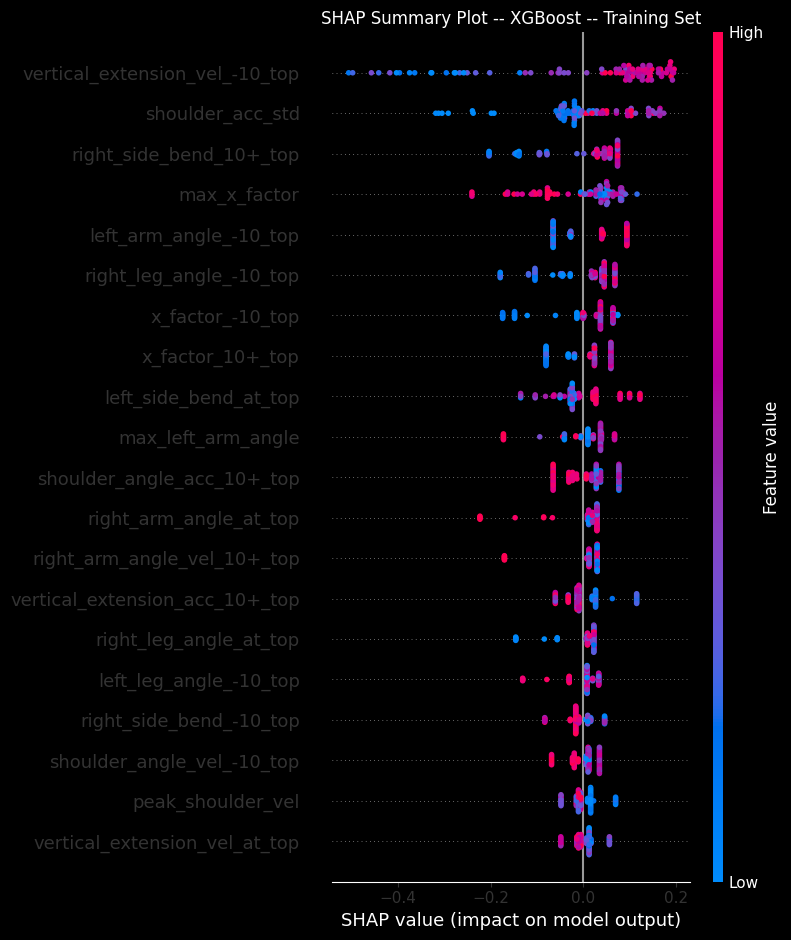

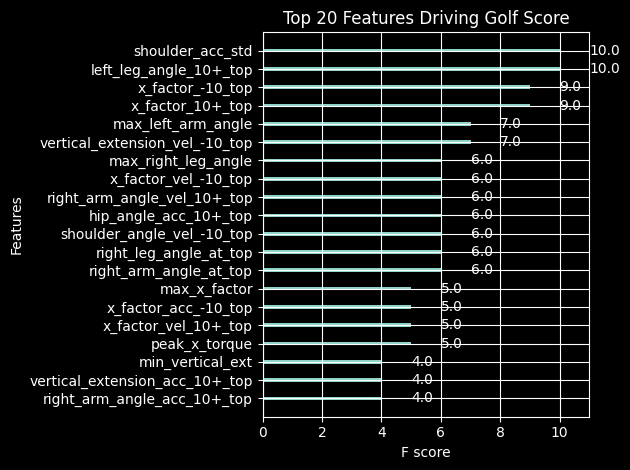

In [72]:
run_xgb(train_x, 
        train_y, 
        test_x,
        test_y,
        n_estimators=1000,           # Lower learning rate requires more trees
        learning_rate=0.15,          # Lower --> Prevents rapid overfitting
        max_depth=3,                 # 2-3 is ideal for small data to force simple logic
        min_child_weight=5,          # Critical: Requires ~5 samples to create a leaf (reduces noise)
        gamma=0.2,                   # Conservative: Minimum loss reduction required to make a split
        subsample=0.9,               # Randomness: Use only 70% of rows per tree
        colsample_bytree=0.9,        # Randomness: Use only 70% of features per tree
        #reg_lambda=1.0,              # L2 Regularization (default is 1, maybe increase to 2-3 if needed)
        early_stopping_rounds=50,    # Stop if validation score doesn't improve
        random_state=42)

In [65]:
# # 1. Initialize (Note: No learning_rate in RF)
#rf_model = RandomForestClassifier(
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=5,             # very shallow
    min_samples_leaf=3,      # each leaf has at least 5 swings
    max_features="sqrt",     # or even a small int
    random_state=0,
    n_jobs=-1,
    oob_score=True
)

# 2. Fit (Same syntax)
rf_model.fit(train_x, train_y)

,n_estimators,500
,criterion,'squared_error'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [40]:
# def train_rf(n_estimators=500, 
#              max_depth=8, 
#              min_samples_leaf=10,
#              max_samples=0.7,
#              max_features='sqrt',
#             ):
#     rf_model = RandomForestRegressor(
#         n_estimators=n_estimators,
#         max_depth=max_depth,   # RFs often grow full trees by default
#         min_samples_leaf=min_samples_leaf,
#         max_features=max_features, # Crucial hyperparameter for RF
#         random_state=42
#     )
#     # 2. Fit (Same syntax)
#     rf_model.fit(X_train, y_train)
#     y_pred = rf_model.predict(X_test)
    
#     mae = mean_absolute_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)
#     return mae, r2

In [41]:
# import itertools
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_error, r2_score

# # 1. Define your lists of parameters to test
# n_estimators_list = [50, 100, 200, 500]
# max_depth_list = [4, 8, 12, 20, None]  # 'None' lets it grow forever (careful!)
# min_samples_leaf_list = [1, 5, 10, 20]

# results = []

# print(f"Starting training on {len(n_estimators_list) * len(max_depth_list) * len(min_samples_leaf_list)} combinations...")

# # itertools.product creates a cartesian product of input iterables
# for n_est, depth, min_samples in itertools.product(n_estimators_list, max_depth_list, min_samples_leaf_list):
    
#     # Run your training function
#     # Note: Ensure X_train, y_train, etc., are defined in your environment before running this
#     mae, r2 = train_rf(n_est, depth, min_samples)
    
#     # Print progress (optional)
#     #print(f"Params: [n={n_est}, depth={depth}, leaf={min_samples}] -> MAE: {mae:.4f}, R2: {r2:.4f}")
    
#     # Save result
#     results.append({
#         'n_estimators': n_est,
#         'max_depth': depth,
#         'min_samples_leaf': min_samples,
#         'MAE': mae,
#         'R2': r2
#     })

# # 4. Convert to DataFrame for analysis
# results_df = pd.DataFrame(results)

# # 5. Sort by Best Performance (Lowest MAE or Highest R2)
# best_results = results_df.sort_values(by='R2', ascending=False)

# print("\nTop 5 Parameter Combinations:")
# print(best_results.head(5))

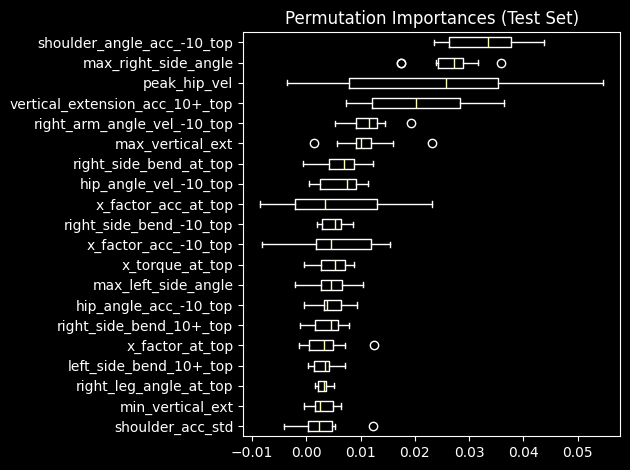

In [42]:
feature_cols = [c for c in df_ready.columns]

result = permutation_importance(
    rf_model, test_x, test_y, 
    n_repeats=10, 
    random_state=42, 
    n_jobs=-1
)

# Sort indices by mean importance
sorted_idx = result.importances_mean.argsort()[-20:] # Top 20

plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False, 
    tick_labels=np.array(feature_cols)[sorted_idx]
)
plt.title("Permutation Importances (Test Set)")
plt.tight_layout()
plt.show()

Model Performance -- Test Set:
Mean Absolute Error (MAE): 1.2174
R-squared Score (R2):      0.0730
Model Performance -- Training Set:
Mean Absolute Error (MAE): 0.6970
R-squared Score (R2):      0.6573


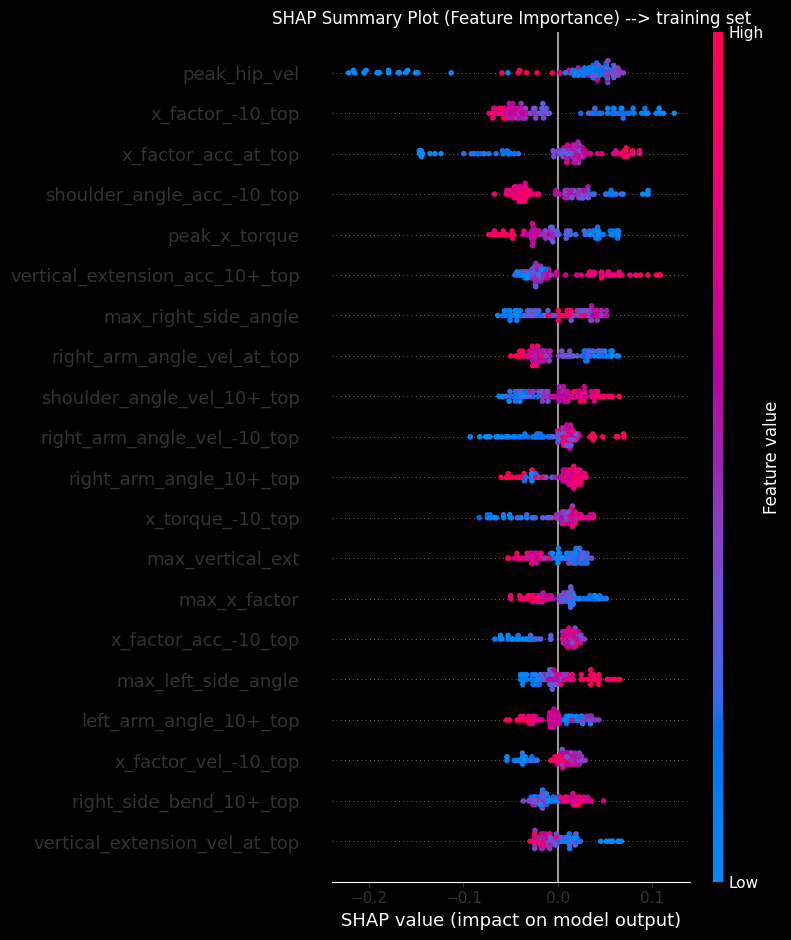

In [43]:
#Validation set
y_pred = rf_model.predict(test_x)

mae = mean_absolute_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)
print("Model Performance -- Test Set:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared Score (R2):      {r2:.4f}")

#Train Results
y_pred = rf_model.predict(train_x)
mae = mean_absolute_error(train_y, y_pred)
r2 = r2_score(train_y, y_pred)

print("Model Performance -- Training Set:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared Score (R2):      {r2:.4f}")

# 5. SHAP Visualization
# Initialize the TreeExplainer (optimized for Random Forests)
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for the test set
# Note: If your dataset is very large, you can pass a sample (e.g., X_test.sample(100)) to speed this up
#shap_values = explainer(X_test)
shap_values = explainer(train_x)

# Create the summary plot (Beeswarm plot)
plt.figure()
plt.title("SHAP Summary Plot (Feature Importance) --> training set")
shap.summary_plot(shap_values, train_x, show=False)
plt.show()

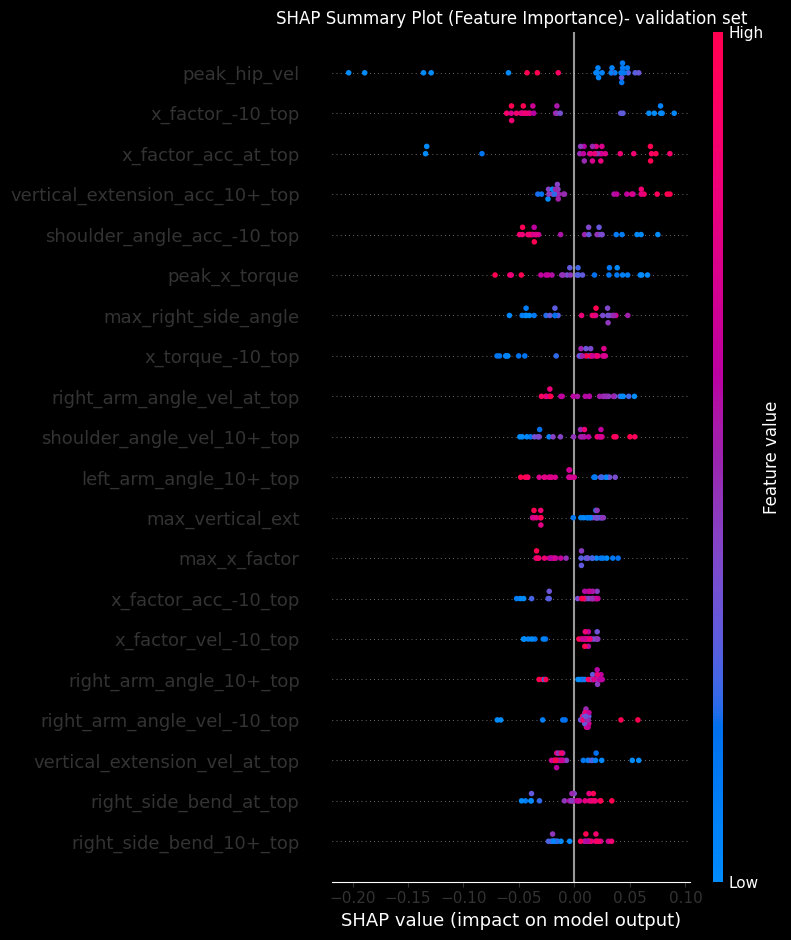

In [44]:
shap_values = explainer(test_x)

# Create the summary plot (Beeswarm plot)
plt.figure()
plt.title("SHAP Summary Plot (Feature Importance)- validation set")
shap.summary_plot(shap_values, test_x, show=False)
#shap.summary_plot(shap_values, X_train, show=False)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

# IMPORTANT: ElasticNet requires feature scaling (RF doesn't)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_x)
X_test_scaled = scaler.transform(test_x)

# ElasticNetCV automatically tunes alpha (regularization strength) and l1_ratio
# l1_ratio: 0 = Ridge (L2), 1 = Lasso (L1), 0.5 = balanced ElasticNet
elastic_cv = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0],  # Mix of L1/L2
    alphas=np.logspace(-4, 1, 50),                    # Regularization strengths
    cv=5,                                             # 5-fold cross-validation
    max_iter=10000,
    random_state=42,
    n_jobs=-1
)

# Fit the model
elastic_cv.fit(X_train_scaled, train_y)

# Predictions
y_train_pred = elastic_cv.predict(X_train_scaled)
y_test_pred = elastic_cv.predict(X_test_scaled)

# Performance metrics
print("=" * 50)
print("ElasticNet Model Performance")
print("=" * 50)
print(f"Best alpha (regularization): {elastic_cv.alpha_:.6f}")
print(f"Best l1_ratio: {elastic_cv.l1_ratio_:.2f}")
print()
print("Test Set:")
print(f"  MAE: {mean_absolute_error(train_y, y_test_pred):.4f}")
print(f"  R²:  {r2_score(test_y, y_test_pred):.4f}")
print()
print("Training Set:")
print(f"  MAE: {mean_absolute_error(train_y, y_train_pred):.4f}")
print(f"  R²:  {r2_score(train_y, y_train_pred):.4f}")

# Feature coefficients (interpretable!)
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': elastic_cv.coef_
}).sort_values('coefficient', key=abs, ascending=False)

print()
print("Top 10 Features by Coefficient Magnitude:")
print("-" * 40)
for idx, row in coef_df.head(10).iterrows():
    print(f"  {row['feature']:35s} {row['coefficient']:+.4f}")

# Count non-zero coefficients (feature selection via L1)
n_nonzero = np.sum(elastic_cv.coef_ != 0)
print(f"\nNon-zero coefficients: {n_nonzero} / {len(elastic_cv.coef_)}")
